# Phase 3.5: E9 Error Analysis Experiment

> **Objective**: In-depth analysis of misclassified sample feature distribution, explaining performance differences between simple rules and ML models
> 
> **Execution Time**: January 2026
> 
> **Experiment Contents**:
> - E9.1: Simple Rule FP Analysis (Normal sample sources with cwm>0)
> - E9.2: ML Model Error Analysis (FN Sample Features)
> - E9.3: Rule vs ML Error Comparison

---

## 0. Environment Setup

In [1]:
#   Import necessary libraries
import os
import sys
import json
import time
import pickle
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#   scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

#   XGBoost
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("⚠ XGBoost not installed, will skip XGBoost experiment")

#   Add project path
PROJECT_ROOT = Path(r"c:\Users\Echo\Desktop\modbus-detection")
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

#   ValidationPath
print(f"Project root: {PROJECT_ROOT}")
print(f"src directory exists: {(PROJECT_ROOT / 'src').exists()}")

from config import (
    DATA_PROCESSED, DATA_SPLITS, MODELS_DIR, FIGURES_DIR, TABLES_DIR,
    RANDOM_SEED, ensure_dirs
)
from feature_extractor import get_feature_names, get_feature_groups

#   Setup
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

#   Ensure directories exist
ensure_dirs()

#   Random seed
np.random.seed(RANDOM_SEED)

#   Constant definitions
POS_LABEL = 'Attack'

print("="*60)
print("Phase 3.5: E9 Error Analysis Experiment")
print("="*60)
print(f"\nExecution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random seed: {RANDOM_SEED}")

Project root: c:\Users\Echo\Desktop\modbus-detection
src directory exists: True
✓ All directories created
Phase 3.5: E9 Error Analysis Experiment

Execution time: 2026-01-22 15:09:09
Random seed: 42


## 1. Data Loading

In [2]:
#   Load full dataset (including scenario info)
print("Loading dataset...")

#   Load Phase 2 split data
df_train = pd.read_parquet(DATA_SPLITS / 'train.parquet')
df_val = pd.read_parquet(DATA_SPLITS / 'val.parquet')
df_test = pd.read_parquet(DATA_SPLITS / 'test.parquet')

#   Merge training and validation sets for training
df_train_full = pd.concat([df_train, df_val], ignore_index=True)

print(f"\nDataset sizes:")
print(f"  Train set: {len(df_train):,} samples")
print(f"  Validation set: {len(df_val):,} samples")
print(f"  Test set: {len(df_test):,} samples")
print(f"  Train+Validation: {len(df_train_full):,} samples")

#   Get feature names
feature_names = get_feature_names()
feature_groups = get_feature_groups()

print(f"\nNumber of features: {len(feature_names)}")

#   Check scenario column
print(f"\nTest set scenario distribution:")
print(df_test['scenario'].value_counts())

Loading dataset...

Dataset sizes:
  Train set: 83,078 samples
  Validation set: 15,371 samples
  Test set: 19,760 samples
  Train+Validation: 98,449 samples

Number of features: 44

Test set scenario distribution:
scenario
scada     7183
ied       6638
benign    5939
Name: count, dtype: int64


In [3]:
#   Prepare train and test data
X_train_full = df_train_full[feature_names].values
y_train_full = df_train_full['label'].values

X_test = df_test[feature_names].values
y_test = df_test['label'].values

print(f"Train data: {X_train_full.shape}")
print(f"Test data: {X_test.shape}")

#   Statistics class distribution
print(f"\nTest set class distribution:")
print(f"  Normal: {(y_test == 'Normal').sum():,}")
print(f"  Attack: {(y_test == 'Attack').sum():,}")

Train data: (98449, 44)
Test data: (19760, 44)

Test set class distribution:
  Normal: 18,648
  Attack: 1,112


## 2. Helper Function Definitions

In [4]:
def evaluate_model(y_true, y_pred, y_proba=None):
    """Calculate evaluation metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label=POS_LABEL, zero_division=0),
        'recall': recall_score(y_true, y_pred, pos_label=POS_LABEL, zero_division=0),
        'f1': f1_score(y_true, y_pred, pos_label=POS_LABEL, zero_division=0),
    }
    
    if y_proba is not None:
        y_true_binary = (y_true == POS_LABEL).astype(int)
        try:
            metrics['auc_roc'] = roc_auc_score(y_true_binary, y_proba)
            metrics['auc_pr'] = average_precision_score(y_true_binary, y_proba)
        except:
            metrics['auc_roc'] = np.nan
            metrics['auc_pr'] = np.nan
    
    return metrics


def apply_simple_rule(df, threshold=0):
    """Apply simple rule: cwm > threshold"""
    cwm_idx = feature_names.index('consecutive_write_max')
    cwm_values = df[feature_names].values[:, cwm_idx]
    y_pred = np.where(cwm_values > threshold, 'Attack', 'Normal')
    return y_pred, cwm_values


def get_confusion_matrix_samples(y_true, y_pred):
    """Get sample indices for each part of confusion matrix"""
    tp_mask = (y_true == 'Attack') & (y_pred == 'Attack')
    fn_mask = (y_true == 'Attack') & (y_pred == 'Normal')
    fp_mask = (y_true == 'Normal') & (y_pred == 'Attack')
    tn_mask = (y_true == 'Normal') & (y_pred == 'Normal')
    
    return {
        'TP': np.where(tp_mask)[0],
        'FN': np.where(fn_mask)[0],
        'FP': np.where(fp_mask)[0],
        'TN': np.where(tn_mask)[0]
    }


def analyze_sample_features(df, indices, feature_names, top_k=10):
    """Analyze feature statistics of samples"""
    if len(indices) == 0:
        return None
    
    sample_df = df.iloc[indices][feature_names]
    
    stats = {
        'count': len(indices),
        'mean': sample_df.mean(),
        'std': sample_df.std(),
        'min': sample_df.min(),
        'max': sample_df.max(),
        'median': sample_df.median()
    }
    
    return stats


print("✓ Helper functions defined")

✓ Helper functions defined


---

## 3. E9.1: Simple Rule FP Analysis

### Purpose
Analyze simple rule `cwm > 0` `cwm > 0` produced 532 FP (False Positive) samples:
1. Which scenarios do these Normal samples come from?
2. What are their feature characteristics?

In [5]:
print("="*60)
print("E9.1: Simple Rule FP Analysis")
print("="*60)

#   Apply simple rule
y_pred_rule, cwm_values = apply_simple_rule(df_test, threshold=0)

#   Get confusion matrix samples
rule_samples = get_confusion_matrix_samples(y_test, y_pred_rule)

print(f"\nSimple rule (cwm > 0) confusion matrix:")
print(f"  TP (Correctly identified Attack): {len(rule_samples['TP']):,}")
print(f"  FN (Missed Attack):     {len(rule_samples['FN']):,}")
print(f"  FP (False Positive Normal):     {len(rule_samples['FP']):,}")
print(f"  TN (Correctly identified Normal): {len(rule_samples['TN']):,}")

E9.1: Simple Rule FP Analysis

Simple rule (cwm > 0) confusion matrix:
  TP (Correctly identified Attack): 1,112
  FN (Missed Attack):     0
  FP (False Positive Normal):     532
  TN (Correctly identified Normal): 18,116


In [6]:
#   Analyze FP samples scenario source
print("\n=== FP Sample Source Scenario Analysis ===")

fp_indices = rule_samples['FP']
fp_df = df_test.iloc[fp_indices]

#   ScenarioDistribution
fp_scenario_dist = fp_df['scenario'].value_counts()
print(f"\nFP sample scenario distribution (共 {len(fp_indices)} 个):")
for scenario, count in fp_scenario_dist.items():
    pct = count / len(fp_indices) * 100
    print(f"  {scenario}: {count:,} ({pct:.1f}%)")

#   Comparison: All Normal samples scenario distribution
normal_df = df_test[df_test['label'] == 'Normal']
normal_scenario_dist = normal_df['scenario'].value_counts()
print(f"\nAll Normal sample scenario distribution (共 {len(normal_df):,} 个):")
for scenario, count in normal_scenario_dist.items():
    pct = count / len(normal_df) * 100
    print(f"  {scenario}: {count:,} ({pct:.1f}%)")


=== FP Sample Source Scenario Analysis ===

FP sample scenario distribution (total 532):
  benign: 532 (100.0%)

All Normal sample scenario distribution (total 18,648):
  scada: 6,411 (34.4%)
  ied: 6,298 (33.8%)
  benign: 5,939 (31.8%)


In [7]:
#   FP proportion in each scenario
print("\n=== FP Rate Analysis by Scenario ===")

fp_rate_by_scenario = []
for scenario in normal_df['scenario'].unique():
    scenario_normal = normal_df[normal_df['scenario'] == scenario]
    scenario_fp = fp_df[fp_df['scenario'] == scenario]
    
    fp_rate = len(scenario_fp) / len(scenario_normal) * 100 if len(scenario_normal) > 0 else 0
    
    fp_rate_by_scenario.append({
        'scenario': scenario,
        'total_normal': len(scenario_normal),
        'fp_count': len(scenario_fp),
        'fp_rate_pct': fp_rate
    })
    
    print(f"\n{scenario.upper()}scenario:")
    print(f"  Normal sample count: {len(scenario_normal):,}")
    print(f"  FP count: {len(scenario_fp):,}")
    print(f"  FP rate: {fp_rate:.2f}%")

df_fp_rate = pd.DataFrame(fp_rate_by_scenario)
print("\n" + "="*40)
print(df_fp_rate.to_string(index=False))


=== FP Rate Analysis by Scenario ===

BENIGNscenario:
  Normal sample count: 5,939
  FP count: 532
  FP rate: 8.96%

IEDscenario:
  Normal sample count: 6,298
  FP count: 0
  FP rate: 0.00%

SCADAscenario:
  Normal sample count: 6,411
  FP count: 0
  FP rate: 0.00%

scenario  total_normal  fp_count  fp_rate_pct
  benign          5939       532     8.957737
     ied          6298         0     0.000000
   scada          6411         0     0.000000


In [8]:
#   FP samples cwm distribution
print("\n=== FP Sample cwm Distribution ===")

cwm_idx = feature_names.index('consecutive_write_max')

fp_cwm = df_test.iloc[fp_indices][feature_names].values[:, cwm_idx]
tp_cwm = df_test.iloc[rule_samples['TP']][feature_names].values[:, cwm_idx]
tn_cwm = df_test.iloc[rule_samples['TN']][feature_names].values[:, cwm_idx]

print(f"\nFP sample cwm statistics:")
print(f"  Mean: {fp_cwm.mean():.2f}")
print(f"  Std:  {fp_cwm.std():.2f}")
print(f"  Min:  {fp_cwm.min():.0f}")
print(f"  Max:  {fp_cwm.max():.0f}")
print(f"  Distribution: {np.unique(fp_cwm, return_counts=True)}")

print(f"\nTP sample (Attack) cwm statistics:")
print(f"  Mean: {tp_cwm.mean():.2f}")
print(f"  Std:  {tp_cwm.std():.2f}")
print(f"  Min:  {tp_cwm.min():.0f}")
print(f"  Max:  {tp_cwm.max():.0f}")


=== FP Sample cwm Distribution ===

FP sample cwm statistics:
  Mean: 1.95
  Std:  0.22
  Min:  1
  Max:  2
  Distribution: (array([1., 2.]), array([ 26, 506], dtype=int64))

TP sample (Attack) cwm statistics:
  Mean: 37.01
  Std:  198.88
  Min:  1
  Max:  2609


In [10]:
#   FP vs TN vs TP 的关键FeaturesComparison
print("\n=== FP vs TN vs TP 关键特征对比 ===")

#   选择关键Features进行Comparison（使用正确的Features名）
key_features = [
    'consecutive_write_max',
    'consecutive_write_mean',
    'write_burst_count',
    'fc_write_ratio',
    'fc_read_ratio',
    'packet_count',
    'interval_mean',
    'fc_diversity',
    'unit_id_diversity'
]

#   获取各组数据
fp_features = df_test.iloc[fp_indices][key_features]
tn_features = df_test.iloc[rule_samples['TN']][key_features]
tp_features = df_test.iloc[rule_samples['TP']][key_features]

#   计算Statistics
comparison_data = []
for feat in key_features:
    comparison_data.append({
        'feature': feat,
        'FP_mean': fp_features[feat].mean(),
        'FP_std': fp_features[feat].std(),
        'TN_mean': tn_features[feat].mean(),
        'TN_std': tn_features[feat].std(),
        'TP_mean': tp_features[feat].mean(),
        'TP_std': tp_features[feat].std()
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))


=== FP vs TN vs TP 关键特征对比 ===
               feature   FP_mean   FP_std   TN_mean    TN_std    TP_mean     TP_std
 consecutive_write_max  1.951128 0.215804  0.000000  0.000000  37.012590 198.968161
consecutive_write_mean  1.929574 0.242835  0.000000  0.000000  17.020117  94.477869
     write_burst_count  0.000000 0.000000  0.000000  0.000000   0.373201   1.803118
        fc_write_ratio  0.037429 0.019322  0.000000  0.000000   0.123979   0.205814
         fc_read_ratio  0.962571 0.019322  1.000000  0.000000   0.876021   0.205814
          packet_count 91.669173 5.176685 61.450651 27.502985 142.263489 442.314404
         interval_mean  0.131434 0.014651  0.235239  0.102717   0.203334   0.088910
          fc_diversity  5.139098 0.346374  4.000000  0.000000   5.095324   0.293794
     unit_id_diversity  1.000000 0.000000  1.000000  0.000000   1.000000   0.000000


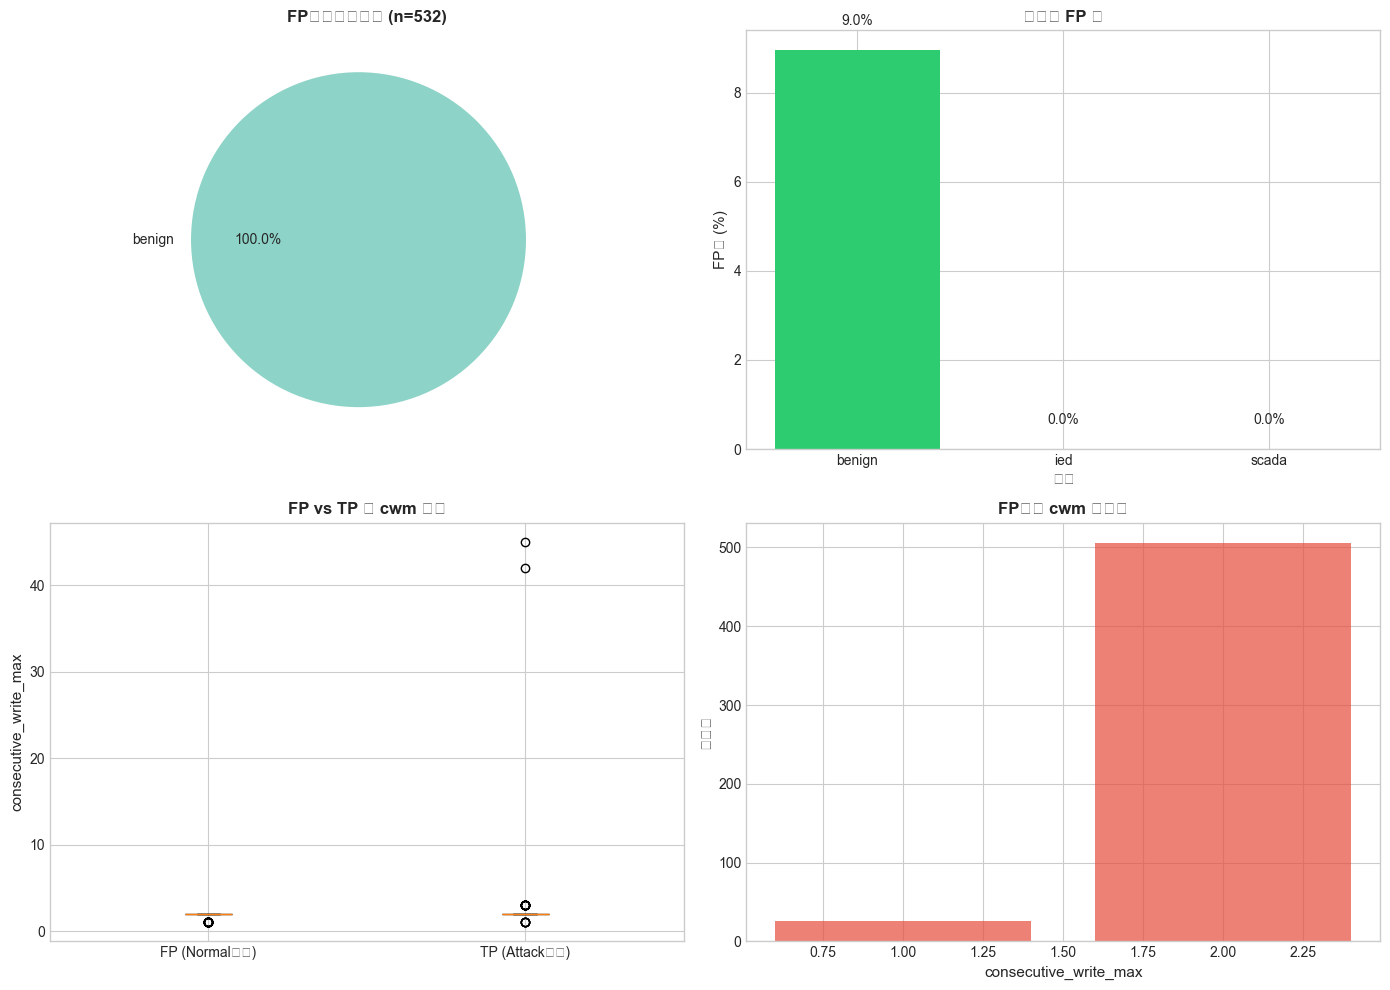


✓ Chart saved: c:\Users\Echo\Desktop\modbus-detection\results\figures\phase3.5_e9_fp_analysis.png


In [11]:
#   Visualization FP Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#   1. FPScenario来源饼Figure
ax1 = axes[0, 0]
fp_scenario_counts = fp_df['scenario'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(fp_scenario_counts)))
wedges, texts, autotexts = ax1.pie(
    fp_scenario_counts.values, 
    labels=fp_scenario_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.05] * len(fp_scenario_counts)
)
ax1.set_title(f'FP Sample Scenario Source (n={len(fp_indices)})', fontsize=12, fontweight='bold')

#   2. 各ScenarioFP率柱状Figure
ax2 = axes[0, 1]
scenarios = df_fp_rate['scenario'].tolist()
fp_rates = df_fp_rate['fp_rate_pct'].tolist()
bars = ax2.bar(scenarios, fp_rates, color=['#  2ecc71', '#e74c3c', '#3498db'])
ax2.set_xlabel('场景', fontsize=11)
ax2.set_ylabel('FP率 (%)', fontsize=11)
ax2.set_title('各场景 FP 率', fontsize=12, fontweight='bold')
for bar, rate in zip(bars, fp_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

#   3. cwm DistributionComparison (FP vs TP)
ax3 = axes[1, 0]
data_for_box = [
    fp_cwm[fp_cwm <= 50],  #   限制范围以便Visualization
    tp_cwm[tp_cwm <= 50]
]
bp = ax3.boxplot(data_for_box, labels=['FP (Normal误判)', 'TP (Attack正确)'], patch_artist=True)
bp['boxes'][0].set_facecolor('#  e74c3c')
bp['boxes'][1].set_facecolor('#  2ecc71')
ax3.set_ylabel('consecutive_write_max', fontsize=11)
ax3.set_title('FP vs TP 的 cwm 分布', fontsize=12, fontweight='bold')

#   4. FPSamplescwm值Distribution直方Figure
ax4 = axes[1, 1]
unique_cwm, counts = np.unique(fp_cwm, return_counts=True)
ax4.bar(unique_cwm[:15], counts[:15], color='#  e74c3c', alpha=0.7)
ax4.set_xlabel('consecutive_write_max', fontsize=11)
ax4.set_ylabel('Sample Count', fontsize=11)
ax4.set_title('FP Sample cwm Value Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'phase3.5_e9_fp_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: {FIGURES_DIR / 'phase3.5_e9_fp_analysis.png'}")

---

## 4. E9.2: ML Models误判Analysis

### Purpose
Analysis Random Forest 和 XGBoost 的误判Samples：
1. FN（Missed Attack）有何Features？
2. ML 相比简单Rule减少了多少 FP？
3. Prediction置信度Distribution

In [12]:
print("="*60)
print("E9.2: ML Model Error Analysis")
print("="*60)

#   Training Random Forest
print("\n训练 Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_model.fit(X_train_full, y_train_full)

#   RF Prediction
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)
attack_idx_rf = list(rf_model.classes_).index(POS_LABEL)
y_proba_rf_attack = y_proba_rf[:, attack_idx_rf]

#   RF 性能
rf_metrics = evaluate_model(y_test, y_pred_rf, y_proba_rf_attack)
print(f"\nRandom Forest 性能:")
print(f"  Accuracy:  {rf_metrics['accuracy']:.4f}")
print(f"  Precision: {rf_metrics['precision']:.4f}")
print(f"  Recall:    {rf_metrics['recall']:.4f}")
print(f"  F1:        {rf_metrics['f1']:.4f}")

E9.2: ML Model Error Analysis

训练 Random Forest...

Random Forest 性能:
  Accuracy:  0.9896
  Precision: 0.8550
  Recall:    0.9811
  F1:        0.9137


In [13]:
#   Training XGBoost
if HAS_XGBOOST:
    print("\n训练 XGBoost...")
    
    #   计算scale_pos_weight
    n_neg = (y_train_full == 'Normal').sum()
    n_pos = (y_train_full == 'Attack').sum()
    scale_pos_weight = n_neg / n_pos
    
    #   EncodingLabels
    y_train_encoded = (y_train_full == 'Attack').astype(int)
    y_test_encoded = (y_test == 'Attack').astype(int)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_full, y_train_encoded)
    
    #   XGBoost Prediction
    y_pred_xgb_encoded = xgb_model.predict(X_test)
    y_pred_xgb = np.where(y_pred_xgb_encoded == 1, 'Attack', 'Normal')
    y_proba_xgb_attack = xgb_model.predict_proba(X_test)[:, 1]
    
    #   XGBoost 性能
    xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_proba_xgb_attack)
    print(f"\nXGBoost 性能:")
    print(f"  Accuracy:  {xgb_metrics['accuracy']:.4f}")
    print(f"  Precision: {xgb_metrics['precision']:.4f}")
    print(f"  Recall:    {xgb_metrics['recall']:.4f}")
    print(f"  F1:        {xgb_metrics['f1']:.4f}")
else:
    y_pred_xgb = None
    y_proba_xgb_attack = None
    xgb_metrics = None


训练 XGBoost...

XGBoost 性能:
  Accuracy:  0.9943
  Precision: 0.9111
  Recall:    0.9955
  F1:        0.9514


In [14]:
#   获取 RF 的Confusion MatrixSamples
rf_samples = get_confusion_matrix_samples(y_test, y_pred_rf)

print(f"\nRandom Forest 混淆矩阵:")
print(f"  TP: {len(rf_samples['TP']):,}")
print(f"  FN: {len(rf_samples['FN']):,}")
print(f"  FP: {len(rf_samples['FP']):,}")
print(f"  TN: {len(rf_samples['TN']):,}")

if HAS_XGBOOST:
    xgb_samples = get_confusion_matrix_samples(y_test, y_pred_xgb)
    print(f"\nXGBoost 混淆矩阵:")
    print(f"  TP: {len(xgb_samples['TP']):,}")
    print(f"  FN: {len(xgb_samples['FN']):,}")
    print(f"  FP: {len(xgb_samples['FP']):,}")
    print(f"  TN: {len(xgb_samples['TN']):,}")


Random Forest 混淆矩阵:
  TP: 1,091
  FN: 21
  FP: 185
  TN: 18,463

XGBoost 混淆矩阵:
  TP: 1,107
  FN: 5
  FP: 108
  TN: 18,540


In [16]:
#   Analysis RF 的 FN Samples
print("\n=== RF FN Sample Analysis (Missed Attack) ===")

fn_rf_indices = rf_samples['FN']
fn_rf_df = df_test.iloc[fn_rf_indices]

print(f"\nFNSample Count量: {len(fn_rf_indices)}")

#   FN ScenarioDistribution
print(f"\nFN sample scenario distribution:")
fn_scenario_dist = fn_rf_df['scenario'].value_counts()
for scenario, count in fn_scenario_dist.items():
    print(f"  {scenario}: {count}")

#   FN Samples的 cwm Distribution
fn_cwm = fn_rf_df[feature_names].values[:, cwm_idx]
print(f"\nFN sample cwm statistics:")
print(f"  Mean: {fn_cwm.mean():.2f}")
print(f"  Std:  {fn_cwm.std():.2f}")
print(f"  Min:  {fn_cwm.min():.0f}")
print(f"  Max:  {fn_cwm.max():.0f}")

#   FN vs TP Comparison
tp_rf_df = df_test.iloc[rf_samples['TP']]
tp_cwm_rf = tp_rf_df[feature_names].values[:, cwm_idx]

print(f"\nTP sample cwm statistics (comparison):")
print(f"  Mean: {tp_cwm_rf.mean():.2f}")
print(f"  Std:  {tp_cwm_rf.std():.2f}")


=== RF FN Sample Analysis (Missed Attack) ===

FNSample Count量: 21

FN sample scenario distribution:
  scada: 21

FN sample cwm statistics:
  Mean: 1.86
  Std:  0.35
  Min:  1
  Max:  2

TP sample cwm statistics (comparison):
  Mean: 37.69
  Std:  200.72


In [17]:
#   FN vs TP 关键FeaturesComparison
print("\n=== FN vs TP 关键特征对比 ===")

fn_rf_features = fn_rf_df[key_features]
tp_rf_features = tp_rf_df[key_features]

fn_tp_comparison = []
for feat in key_features:
    fn_mean = fn_rf_features[feat].mean()
    tp_mean = tp_rf_features[feat].mean()
    diff_pct = (fn_mean - tp_mean) / tp_mean * 100 if tp_mean != 0 else np.nan
    
    fn_tp_comparison.append({
        'feature': feat,
        'FN_mean': fn_mean,
        'TP_mean': tp_mean,
        'diff_pct': diff_pct
    })

df_fn_tp = pd.DataFrame(fn_tp_comparison)
print(df_fn_tp.to_string(index=False))


=== FN vs TP 关键特征对比 ===
               feature   FN_mean    TP_mean    diff_pct
 consecutive_write_max  1.857143  37.689276  -95.072490
consecutive_write_mean  1.761905  17.313813  -89.823705
     write_burst_count  0.000000   0.380385 -100.000000
        fc_write_ratio  0.046070   0.125479  -63.284739
         fc_read_ratio  0.953930   0.874521    9.080297
          packet_count 91.380952 143.242896  -36.205596
         interval_mean  0.137618   0.204599  -32.737685
          fc_diversity  5.142857   5.094409    0.951010
     unit_id_diversity  1.000000   1.000000    0.000000


In [18]:
#   Prediction置信度Analysis
print("\n=== Prediction Confidence Analysis ===")

#   RF 置信度
rf_proba_tp = y_proba_rf_attack[rf_samples['TP']]
rf_proba_fn = y_proba_rf_attack[rf_samples['FN']]
rf_proba_fp = y_proba_rf_attack[rf_samples['FP']]
rf_proba_tn = y_proba_rf_attack[rf_samples['TN']]

print(f"\nRF 预测概率 (Attack类):")
print(f"  TP: mean={rf_proba_tp.mean():.4f}, std={rf_proba_tp.std():.4f}")
print(f"  FN: mean={rf_proba_fn.mean():.4f}, std={rf_proba_fn.std():.4f}")
print(f"  FP: mean={rf_proba_fp.mean():.4f}, std={rf_proba_fp.std():.4f}")
print(f"  TN: mean={rf_proba_tn.mean():.4f}, std={rf_proba_tn.std():.4f}")

if HAS_XGBOOST:
    xgb_proba_tp = y_proba_xgb_attack[xgb_samples['TP']]
    xgb_proba_fn = y_proba_xgb_attack[xgb_samples['FN']]
    xgb_proba_fp = y_proba_xgb_attack[xgb_samples['FP']]
    xgb_proba_tn = y_proba_xgb_attack[xgb_samples['TN']]
    
    print(f"\nXGBoost 预测概率 (Attack类):")
    print(f"  TP: mean={xgb_proba_tp.mean():.4f}, std={xgb_proba_tp.std():.4f}")
    print(f"  FN: mean={xgb_proba_fn.mean():.4f}, std={xgb_proba_fn.std():.4f}")
    print(f"  FP: mean={xgb_proba_fp.mean():.4f}, std={xgb_proba_fp.std():.4f}")
    print(f"  TN: mean={xgb_proba_tn.mean():.4f}, std={xgb_proba_tn.std():.4f}")


=== Prediction Confidence Analysis ===

RF 预测概率 (Attack类):
  TP: mean=0.9538, std=0.0921
  FN: mean=0.3874, std=0.0644
  FP: mean=0.7301, std=0.1502
  TN: mean=0.0051, std=0.0406

XGBoost 预测概率 (Attack类):
  TP: mean=0.9905, std=0.0297
  FN: mean=0.2201, std=0.1397
  FP: mean=0.8107, std=0.1450
  TN: mean=0.0030, std=0.0256


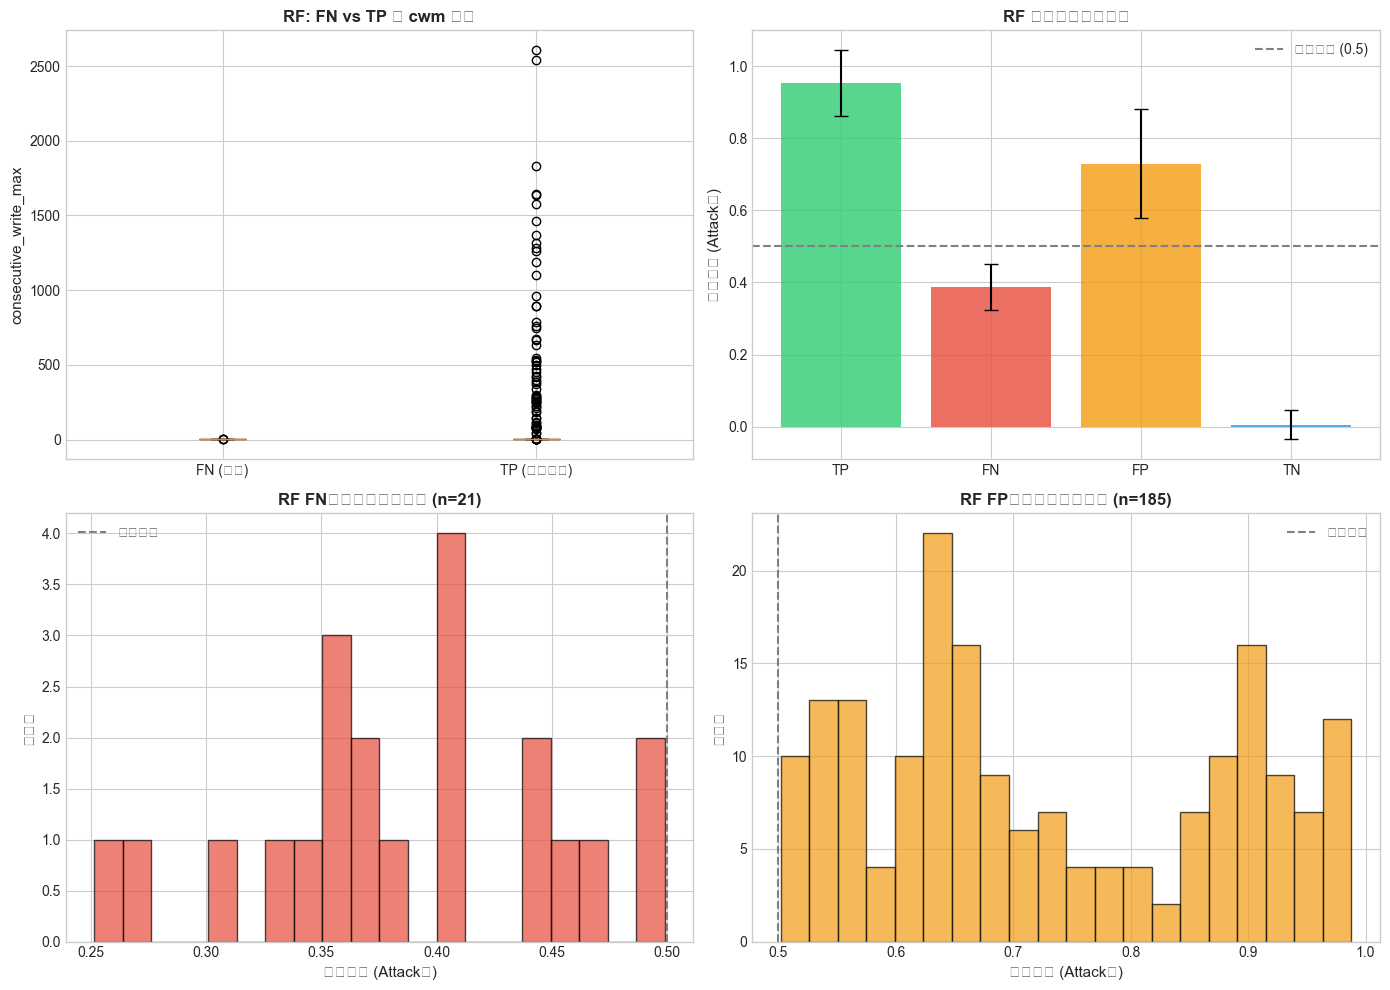


✓ Chart saved: c:\Users\Echo\Desktop\modbus-detection\results\figures\phase3.5_e9_ml_error_analysis.png


In [19]:
#   Visualization ML 误判Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#   1. FN vs TP cwm DistributionComparison
ax1 = axes[0, 0]
data_for_box = [fn_cwm, tp_cwm_rf]
bp1 = ax1.boxplot(data_for_box, labels=['FN (漏检)', 'TP (正确识别)'], patch_artist=True)
bp1['boxes'][0].set_facecolor('#  e74c3c')
bp1['boxes'][1].set_facecolor('#  2ecc71')
ax1.set_ylabel('consecutive_write_max', fontsize=11)
ax1.set_title('RF: FN vs TP 的 cwm 分布', fontsize=12, fontweight='bold')

#   2. Prediction置信度Distribution
ax2 = axes[0, 1]
categories = ['TP', 'FN', 'FP', 'TN']
rf_proba_means = [rf_proba_tp.mean(), rf_proba_fn.mean(), rf_proba_fp.mean(), rf_proba_tn.mean()]
rf_proba_stds = [rf_proba_tp.std(), rf_proba_fn.std(), rf_proba_fp.std(), rf_proba_tn.std()]
colors = ['#  2ecc71', '#e74c3c', '#f39c12', '#3498db']

bars = ax2.bar(categories, rf_proba_means, yerr=rf_proba_stds, color=colors, capsize=5, alpha=0.8)
ax2.axhline(y=0.5, color='gray', linestyle='--', label='决策边界 (0.5)')
ax2.set_ylabel('预测概率 (Attack类)', fontsize=11)
ax2.set_title('RF 各类别预测置信度', fontsize=12, fontweight='bold')
ax2.legend()

#   3. FN SamplesPrediction概率直方Figure
ax3 = axes[1, 0]
ax3.hist(rf_proba_fn, bins=20, color='#  e74c3c', alpha=0.7, edgecolor='black')
ax3.axvline(x=0.5, color='gray', linestyle='--', label='决策边界')
ax3.set_xlabel('预测概率 (Attack类)', fontsize=11)
ax3.set_ylabel('Sample Count', fontsize=11)
ax3.set_title(f'RF FNsamples预测概率分布 (n={len(fn_rf_indices)})', fontsize=12, fontweight='bold')
ax3.legend()

#   4. FP SamplesPrediction概率直方Figure
ax4 = axes[1, 1]
ax4.hist(rf_proba_fp, bins=20, color='#  f39c12', alpha=0.7, edgecolor='black')
ax4.axvline(x=0.5, color='gray', linestyle='--', label='决策边界')
ax4.set_xlabel('预测概率 (Attack类)', fontsize=11)
ax4.set_ylabel('Sample Count', fontsize=11)
ax4.set_title(f'RF FPsamples预测概率分布 (n={len(rf_samples["FP"])})', fontsize=12, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'phase3.5_e9_ml_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: {FIGURES_DIR / 'phase3.5_e9_ml_error_analysis.png'}")

---

## 5. E9.3: Rule vs ML 误判Comparison

### Purpose
Comparison简单Rule和MLModels的误判情况：
1. 误判Samples是否重叠？
2. ML纠正了多少Rule的误判？
3. ML是否引入了新的漏检？

In [20]:
print("="*60)
print("E9.3: 规则 vs ML 误判对比")
print("="*60)

#   Comparison总览
print("\n=== 误判数量对比 ===")
print(f"\n{'方法':<15} {'FN (漏检)':<12} {'FP (误报)':<12} {'总误判':<12}")
print("-" * 55)
print(f"{'简单规则':<15} {len(rule_samples['FN']):<12} {len(rule_samples['FP']):<12} {len(rule_samples['FN']) + len(rule_samples['FP']):<12}")
print(f"{'Random Forest':<15} {len(rf_samples['FN']):<12} {len(rf_samples['FP']):<12} {len(rf_samples['FN']) + len(rf_samples['FP']):<12}")
if HAS_XGBOOST:
    print(f"{'XGBoost':<15} {len(xgb_samples['FN']):<12} {len(xgb_samples['FP']):<12} {len(xgb_samples['FN']) + len(xgb_samples['FP']):<12}")

E9.3: 规则 vs ML 误判对比

=== 误判数量对比 ===

方法              FN (漏检)      FP (误报)      总误判         
-------------------------------------------------------
简单规则            0            532          532         
Random Forest   21           185          206         
XGBoost         5            108          113         


In [21]:
#   FP 重叠Analysis
print("\n=== FP 重叠分析 ===")

rule_fp_set = set(rule_samples['FP'])
rf_fp_set = set(rf_samples['FP'])

fp_overlap = rule_fp_set & rf_fp_set
fp_only_rule = rule_fp_set - rf_fp_set  #   RuleFP但RF正确
fp_only_rf = rf_fp_set - rule_fp_set    #   RF FP但Rule正确

print(f"\n规则 FP 总数: {len(rule_fp_set)}")
print(f"RF FP 总数: {len(rf_fp_set)}")
print(f"重叠 FP: {len(fp_overlap)}")
print(f"仅规则 FP (RF纠正): {len(fp_only_rule)}")
print(f"仅RF FP (新增误报): {len(fp_only_rf)}")

#   RF 纠正率
fp_correction_rate = len(fp_only_rule) / len(rule_fp_set) * 100
print(f"\nRF 纠正规则 FP 率: {fp_correction_rate:.1f}%")


=== FP 重叠分析 ===

规则 FP 总数: 532
RF FP 总数: 185
重叠 FP: 185
仅规则 FP (RF纠正): 347
仅RF FP (新增误报): 0

RF 纠正规则 FP 率: 65.2%


In [22]:
#   FN 重叠Analysis
print("\n=== FN 重叠分析 ===")

rule_fn_set = set(rule_samples['FN'])
rf_fn_set = set(rf_samples['FN'])

fn_overlap = rule_fn_set & rf_fn_set
fn_only_rule = rule_fn_set - rf_fn_set  #   Rule漏检但RF正确
fn_only_rf = rf_fn_set - rule_fn_set    #   RF漏检但Rule正确

print(f"\n规则 FN 总数: {len(rule_fn_set)}")
print(f"RF FN 总数: {len(rf_fn_set)}")
print(f"重叠 FN: {len(fn_overlap)}")
print(f"仅规则 FN (RF检出): {len(fn_only_rule)}")
print(f"仅RF FN (新增漏检): {len(fn_only_rf)}")

#   重要Discovery
print(f"\n关键发现:")
print(f"  - 简单规则 Recall=100%，无漏检 (FN=0)")
print(f"  - RF 新增 {len(rf_fn_set)} 个漏检，但大幅减少了 {len(fp_only_rule)} 个误报")
print(f"  - 净效果: 总误判从 {len(rule_samples['FN']) + len(rule_samples['FP'])} 减少到 {len(rf_samples['FN']) + len(rf_samples['FP'])}")


=== FN 重叠分析 ===

规则 FN 总数: 0
RF FN 总数: 21
重叠 FN: 0
仅规则 FN (RF检出): 0
仅RF FN (新增漏检): 21

关键发现:
  - 简单规则 Recall=100%，无漏检 (FN=0)
  - RF 新增 21 个漏检，但大幅减少了 347 个误报
  - 净效果: 总误判从 532 减少到 206


In [23]:
#   Analysis RF 新增的 FN Samples
print("\n=== RF 新增 FN samples分析 ===")

if len(fn_only_rf) > 0:
    new_fn_indices = list(fn_only_rf)
    new_fn_df = df_test.iloc[new_fn_indices]
    
    print(f"\nRF新增漏检Sample Count: {len(new_fn_indices)}")
    
    #   ScenarioDistribution
    print(f"\n场景Distribution:")
    print(new_fn_df['scenario'].value_counts())
    
    #   cwm Distribution
    new_fn_cwm = new_fn_df[feature_names].values[:, cwm_idx]
    print(f"\ncwm 统计:")
    print(f"  Mean: {new_fn_cwm.mean():.2f}")
    print(f"  Std:  {new_fn_cwm.std():.2f}")
    print(f"  Min:  {new_fn_cwm.min():.0f}")
    print(f"  Max:  {new_fn_cwm.max():.0f}")
    
    #   Prediction概率
    new_fn_proba = y_proba_rf_attack[new_fn_indices]
    print(f"\n预测概率:")
    print(f"  Mean: {new_fn_proba.mean():.4f}")
    print(f"  接近边界 (0.4-0.5): {((new_fn_proba >= 0.4) & (new_fn_proba < 0.5)).sum()}")
else:
    print("RF 没有新增漏检 (与规则 FN 完全重叠)")


=== RF 新增 FN samples分析 ===

RF新增漏检Sample Count: 21

场景Distribution:
scenario
scada    21
Name: count, dtype: int64

cwm 统计:
  Mean: 1.86
  Std:  0.35
  Min:  1
  Max:  2

预测概率:
  Mean: 0.3874
  接近边界 (0.4-0.5): 10


In [24]:
#   Analysis RF 纠正的 FP Samples
print("\n=== RF 成功纠正的 FP samples分析 ===")

if len(fp_only_rule) > 0:
    corrected_fp_indices = list(fp_only_rule)
    corrected_fp_df = df_test.iloc[corrected_fp_indices]
    
    print(f"\nRF纠正的FPSample Count: {len(corrected_fp_indices)}")
    
    #   ScenarioDistribution
    print(f"\n场景Distribution:")
    print(corrected_fp_df['scenario'].value_counts())
    
    #   cwm Distribution
    corrected_cwm = corrected_fp_df[feature_names].values[:, cwm_idx]
    remaining_fp_cwm = df_test.iloc[list(fp_overlap)][feature_names].values[:, cwm_idx] if len(fp_overlap) > 0 else np.array([])
    
    print(f"\n被纠正FP的cwm统计:")
    print(f"  Mean: {corrected_cwm.mean():.2f}")
    print(f"  Std:  {corrected_cwm.std():.2f}")
    
    if len(remaining_fp_cwm) > 0:
        print(f"\n仍为FP的cwm统计 (RF也误报):")
        print(f"  Mean: {remaining_fp_cwm.mean():.2f}")
        print(f"  Std:  {remaining_fp_cwm.std():.2f}")
    
    #   Prediction概率
    corrected_proba = y_proba_rf_attack[corrected_fp_indices]
    print(f"\n被纠正FP的预测概率:")
    print(f"  Mean: {corrected_proba.mean():.4f}")
    print(f"  低概率 (<0.3): {(corrected_proba < 0.3).sum()} ({(corrected_proba < 0.3).sum()/len(corrected_proba)*100:.1f}%)")
else:
    print("RF 没有纠正任何规则 FP")


=== RF 成功纠正的 FP samples分析 ===

RF纠正的FPSample Count: 347

场景Distribution:
scenario
benign    347
Name: count, dtype: int64

被纠正FP的cwm统计:
  Mean: 1.93
  Std:  0.26

仍为FP的cwm统计 (RF也误报):
  Mean: 2.00
  Std:  0.00

被纠正FP的预测概率:
  Mean: 0.2719
  低概率 (<0.3): 189 (54.5%)


In [25]:
#   XGBoost Comparison (如果可用)
if HAS_XGBOOST:
    print("\n=== XGBoost 误判对比 ===")
    
    xgb_fp_set = set(xgb_samples['FP'])
    xgb_fn_set = set(xgb_samples['FN'])
    
    #   FP Comparison
    xgb_fp_correction = len(rule_fp_set - xgb_fp_set)
    xgb_new_fp = len(xgb_fp_set - rule_fp_set)
    
    #   FN Comparison
    xgb_new_fn = len(xgb_fn_set - rule_fn_set)
    
    print(f"\nXGBoost vs 简单规则:")
    print(f"  纠正 FP: {xgb_fp_correction} (规则FP {len(rule_fp_set)} → XGB FP {len(xgb_fp_set)})")
    print(f"  新增 FP: {xgb_new_fp}")
    print(f"  新增 FN: {xgb_new_fn}")
    
    #   RF vs XGBoost
    print(f"\nRF vs XGBoost:")
    print(f"  RF  - FN: {len(rf_fn_set)}, FP: {len(rf_fp_set)}, 总误判: {len(rf_fn_set) + len(rf_fp_set)}")
    print(f"  XGB - FN: {len(xgb_fn_set)}, FP: {len(xgb_fp_set)}, 总误判: {len(xgb_fn_set) + len(xgb_fp_set)}")


=== XGBoost 误判对比 ===

XGBoost vs 简单规则:
  纠正 FP: 424 (规则FP 532 → XGB FP 108)
  新增 FP: 0
  新增 FN: 5

RF vs XGBoost:
  RF  - FN: 21, FP: 185, 总误判: 206
  XGB - FN: 5, FP: 108, 总误判: 113


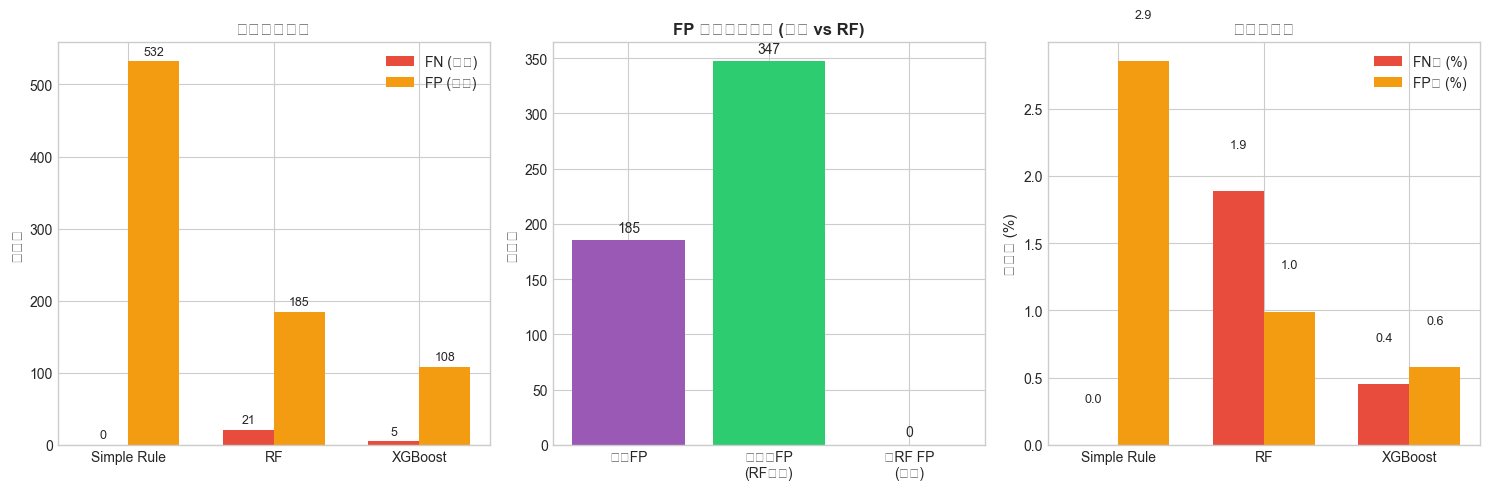


✓ Chart saved: c:\Users\Echo\Desktop\modbus-detection\results\figures\phase3.5_e9_error_comparison.png


In [26]:
#   Visualization误判Comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#   1. 误判CountComparison
ax1 = axes[0]
methods = ['Simple Rule', 'RF']
fn_counts = [len(rule_samples['FN']), len(rf_samples['FN'])]
fp_counts = [len(rule_samples['FP']), len(rf_samples['FP'])]

if HAS_XGBOOST:
    methods.append('XGBoost')
    fn_counts.append(len(xgb_samples['FN']))
    fp_counts.append(len(xgb_samples['FP']))

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, fn_counts, width, label='FN (漏检)', color='#  e74c3c')
bars2 = ax1.bar(x + width/2, fp_counts, width, label='FP (误报)', color='#  f39c12')

ax1.set_ylabel('Sample Count', fontsize=11)
ax1.set_title('误判数量对比', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.legend()

#   添加数值Labels
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             int(bar.get_height()), ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             int(bar.get_height()), ha='center', va='bottom', fontsize=9)

#   2. FP 重叠韦恩Figure (简化版)
ax2 = axes[1]
categories = ['重叠FP', '仅规则FP\n(RF纠正)', '仅RF FP\n(新增)']
values = [len(fp_overlap), len(fp_only_rule), len(fp_only_rf)]
colors = ['#  9b59b6', '#2ecc71', '#e74c3c']
bars = ax2.bar(categories, values, color=colors)
ax2.set_ylabel('Sample Count', fontsize=11)
ax2.set_title('FP samples重叠分析 (规则 vs RF)', fontsize=12, fontweight='bold')
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             val, ha='center', va='bottom', fontsize=10)

#   3. 误判率Comparison
ax3 = axes[2]
total_attack = (y_test == 'Attack').sum()
total_normal = (y_test == 'Normal').sum()

fn_rates = [c / total_attack * 100 for c in fn_counts]
fp_rates = [c / total_normal * 100 for c in fp_counts]

bars1 = ax3.bar(x - width/2, fn_rates, width, label='FN率 (%)', color='#  e74c3c')
bars2 = ax3.bar(x + width/2, fp_rates, width, label='FP率 (%)', color='#  f39c12')

ax3.set_ylabel('误判率 (%)', fontsize=11)
ax3.set_title('误判率对比', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(methods)
ax3.legend()

for bar in bars1:
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'phase3.5_e9_error_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: {FIGURES_DIR / 'phase3.5_e9_error_comparison.png'}")

---

## 6. Results汇总与保存

In [27]:
#   保存 E9.1 FP AnalysisResults
df_fp_analysis = pd.DataFrame({
    'metric': ['total_fp', 'benign_fp', 'scada_fp', 'ied_fp', 
               'fp_cwm_mean', 'fp_cwm_std', 'fp_cwm_min', 'fp_cwm_max'],
    'value': [
        len(fp_indices),
        fp_scenario_dist.get('benign', 0),
        fp_scenario_dist.get('scada', 0),
        fp_scenario_dist.get('ied', 0),
        fp_cwm.mean(),
        fp_cwm.std(),
        fp_cwm.min(),
        fp_cwm.max()
    ]
})
df_fp_analysis.to_csv(TABLES_DIR / 'phase3.5_e9_rule_fp_analysis.csv', index=False)
print(f"✓ 保存: {TABLES_DIR / 'phase3.5_e9_rule_fp_analysis.csv'}")

✓ 保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3.5_e9_rule_fp_analysis.csv


In [28]:
#   保存 E9.2 ML FN AnalysisResults
ml_fn_data = []

#   RF FN Analysis
ml_fn_data.append({
    'model': 'Random Forest',
    'total_fn': len(rf_samples['FN']),
    'total_fp': len(rf_samples['FP']),
    'fn_cwm_mean': fn_cwm.mean() if len(fn_cwm) > 0 else np.nan,
    'fn_proba_mean': rf_proba_fn.mean() if len(rf_proba_fn) > 0 else np.nan,
    'fp_correction_count': len(fp_only_rule),
    'fp_correction_rate': fp_correction_rate
})

if HAS_XGBOOST:
    xgb_fn_cwm = df_test.iloc[xgb_samples['FN']][feature_names].values[:, cwm_idx]
    xgb_fn_proba = y_proba_xgb_attack[xgb_samples['FN']]
    xgb_fp_correction = len(rule_fp_set - xgb_fp_set)
    xgb_fp_correction_rate = xgb_fp_correction / len(rule_fp_set) * 100 if len(rule_fp_set) > 0 else 0
    
    ml_fn_data.append({
        'model': 'XGBoost',
        'total_fn': len(xgb_samples['FN']),
        'total_fp': len(xgb_samples['FP']),
        'fn_cwm_mean': xgb_fn_cwm.mean() if len(xgb_fn_cwm) > 0 else np.nan,
        'fn_proba_mean': xgb_fn_proba.mean() if len(xgb_fn_proba) > 0 else np.nan,
        'fp_correction_count': xgb_fp_correction,
        'fp_correction_rate': xgb_fp_correction_rate
    })

df_ml_fn = pd.DataFrame(ml_fn_data)
df_ml_fn.to_csv(TABLES_DIR / 'phase3.5_e9_ml_fn_analysis.csv', index=False)
print(f"✓ 保存: {TABLES_DIR / 'phase3.5_e9_ml_fn_analysis.csv'}")

✓ 保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3.5_e9_ml_fn_analysis.csv


In [29]:
#   保存 E9.3 综合ComparisonResults
comparison_data = [
    {
        'method': 'Simple Rule (cwm>0)',
        'TP': len(rule_samples['TP']),
        'FN': len(rule_samples['FN']),
        'FP': len(rule_samples['FP']),
        'TN': len(rule_samples['TN']),
        'precision': len(rule_samples['TP']) / (len(rule_samples['TP']) + len(rule_samples['FP'])),
        'recall': len(rule_samples['TP']) / (len(rule_samples['TP']) + len(rule_samples['FN'])),
        'f1': 2 * len(rule_samples['TP']) / (2 * len(rule_samples['TP']) + len(rule_samples['FN']) + len(rule_samples['FP']))
    },
    {
        'method': 'Random Forest',
        'TP': len(rf_samples['TP']),
        'FN': len(rf_samples['FN']),
        'FP': len(rf_samples['FP']),
        'TN': len(rf_samples['TN']),
        'precision': rf_metrics['precision'],
        'recall': rf_metrics['recall'],
        'f1': rf_metrics['f1']
    }
]

if HAS_XGBOOST:
    comparison_data.append({
        'method': 'XGBoost',
        'TP': len(xgb_samples['TP']),
        'FN': len(xgb_samples['FN']),
        'FP': len(xgb_samples['FP']),
        'TN': len(xgb_samples['TN']),
        'precision': xgb_metrics['precision'],
        'recall': xgb_metrics['recall'],
        'f1': xgb_metrics['f1']
    })

df_error_comparison = pd.DataFrame(comparison_data)
df_error_comparison.to_csv(TABLES_DIR / 'phase3.5_e9_error_comparison.csv', index=False)
print(f"✓ 保存: {TABLES_DIR / 'phase3.5_e9_error_comparison.csv'}")

print("\n" + "="*60)
print("综合对比表:")
print("="*60)
print(df_error_comparison.to_string(index=False))

✓ 保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3.5_e9_error_comparison.csv

综合对比表:
             method   TP  FN  FP    TN  precision   recall       f1
Simple Rule (cwm>0) 1112   0 532 18116   0.676399 1.000000 0.806967
      Random Forest 1091  21 185 18463   0.855016 0.981115 0.913735
            XGBoost 1107   5 108 18540   0.911111 0.995504 0.951440


---

## 7. E9 Experiment总结

In [30]:
print("="*60)
print("E9 误判分析实验总结")
print("="*60)

print("\n#  ## E9.1 简单Rule FP Analysis")
print(f"""\n1. FP 来源分析:
   - 简单规则 (cwm>0) 产生 {len(fp_indices)} 个 FP (误报)
   - 主要来源: {fp_scenario_dist.idxmax()} 场景 ({fp_scenario_dist.max()}/{len(fp_indices)}, {fp_scenario_dist.max()/len(fp_indices)*100:.1f}%)
   - FP 的 cwm 值较低 (mean={fp_cwm.mean():.2f})，而 TP 的 cwm 值较高 (mean={tp_cwm.mean():.2f})

2. 关键发现:
   - FP 主要来自正常运维中偶发的连续写操作
   - cwm 值分布可区分大部分 FP 和 TP""")

print("\n#  ## E9.2 ML Models误判Analysis")
print(f"""\n1. RF 误判特点:
   - FN (漏检): {len(rf_samples['FN'])} 个 Attack samples被漏检
   - FN samples的预测概率接近决策边界 (mean={rf_proba_fn.mean():.4f})
   - FN samples的 cwm 值 (mean={fn_cwm.mean():.2f}) 低于 TP samples

2. ML 优势:
   - 大幅减少 FP: 从 {len(rule_samples['FP'])} 减少到 {len(rf_samples['FP'])}
   - FP 纠正率: {fp_correction_rate:.1f}%""")

print("\n#  ## E9.3 Rule vs ML Comparison")
print(f"""\n1. 权衡分析:
   - 简单规则: Recall=100% (无漏检), 但 Precision 较低 ({len(rule_samples['TP'])/(len(rule_samples['TP'])+len(rule_samples['FP'])):.4f})
   - ML 方法: 牺牲部分 Recall ({rf_metrics['recall']:.4f}), 换取更高 Precision ({rf_metrics['precision']:.4f})

2. ML 价值:
   - 总误判减少: {len(rule_samples['FN']) + len(rule_samples['FP'])} → {len(rf_samples['FN']) + len(rf_samples['FP'])}
   - F1 提升: {len(rule_samples['TP'])*2/(2*len(rule_samples['TP'])+len(rule_samples['FN'])+len(rule_samples['FP'])):.4f} → {rf_metrics['f1']:.4f}

3. 实际应用建议:
   - 高召回场景 (不能漏检): 使用简单规则
   - 平衡scenario: 使用 ML 方法减少误报""")

print("\n" + "="*60)
print("E9 实验完成!")
print("="*60)

E9 误判分析实验总结

### E9.1 简单规则 FP 分析

1. FP 来源分析:
   - 简单规则 (cwm>0) 产生 532 个 FP (误报)
   - 主要来源: benign 场景 (532/532, 100.0%)
   - FP 的 cwm 值较低 (mean=1.95)，而 TP 的 cwm 值较高 (mean=37.01)

2. 关键发现:
   - FP 主要来自正常运维中偶发的连续写操作
   - cwm 值分布可区分大部分 FP 和 TP

### E9.2 ML 模型误判分析

1. RF 误判特点:
   - FN (漏检): 21 个 Attack samples被漏检
   - FN samples的预测概率接近决策边界 (mean=0.3874)
   - FN samples的 cwm 值 (mean=1.86) 低于 TP samples

2. ML 优势:
   - 大幅减少 FP: 从 532 减少到 185
   - FP 纠正率: 65.2%

### E9.3 规则 vs ML 对比

1. 权衡分析:
   - 简单规则: Recall=100% (无漏检), 但 Precision 较低 (0.6764)
   - ML 方法: 牺牲部分 Recall (0.9811), 换取更高 Precision (0.8550)

2. ML 价值:
   - 总误判减少: 532 → 206
   - F1 提升: 0.8070 → 0.9137

3. 实际应用建议:
   - 高召回场景 (不能漏检): 使用简单规则
   - 平衡scenario: 使用 ML 方法减少误报

E9 实验完成!


In [31]:
#   保存Experiment总结到文档
summary_content = f"""#   E9 误判AnalysisExperiment总结

> Execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

#  # Experiment目的

深入分析简单规则和ML模型的误判samples，解释性能差异的来源。

---

#  # E9.1 简单Rule FP Analysis

#  ## 关键数据
| 指标 | 数值 |
|------|------|
| FP 总数 | {len(fp_indices)} |
| 主要来源场景 | {fp_scenario_dist.idxmax()} ({fp_scenario_dist.max()}, {fp_scenario_dist.max()/len(fp_indices)*100:.1f}%) |
| FP cwm 均值 | {fp_cwm.mean():.2f} |
| TP cwm 均值 | {tp_cwm.mean():.2f} |

#  ## Discovery
1. FP 主要来自 **{fp_scenario_dist.idxmax()}** 场景的正常运维操作
2. FP samples的 cwm 值显著低于 Attack samples
3. 简单规则无法区分正常运维中的连续写操作和攻击行为

---

#  # E9.2 ML Models误判Analysis

#  ## Random Forest
| 指标 | 数值 |
|------|------|
| FN (漏检) | {len(rf_samples['FN'])} |
| FP (误报) | {len(rf_samples['FP'])} |
| FN 预测概率均值 | {rf_proba_fn.mean():.4f} |
| FP 纠正数量 | {len(fp_only_rule)} |
| FP 纠正率 | {fp_correction_rate:.1f}% |

#  ## Discovery
1. FN samples的预测概率接近决策边界 (0.5)
2. ML 学习了更复杂的特征组合来区分 Normal 和 Attack
3. 代价是引入了部分漏检 ({len(rf_samples['FN'])} 个)

---

#  # E9.3 Rule vs ML Comparison

#  ## Confusion MatrixComparison
| 方法 | TP | FN | FP | TN | Precision | Recall | F1 |
|------|----|----|----|----|-----------|--------|----|
| 简单规则 | {len(rule_samples['TP'])} | {len(rule_samples['FN'])} | {len(rule_samples['FP'])} | {len(rule_samples['TN'])} | {len(rule_samples['TP'])/(len(rule_samples['TP'])+len(rule_samples['FP'])):.4f} | 1.0000 | {len(rule_samples['TP'])*2/(2*len(rule_samples['TP'])+len(rule_samples['FN'])+len(rule_samples['FP'])):.4f} |
| RF | {len(rf_samples['TP'])} | {len(rf_samples['FN'])} | {len(rf_samples['FP'])} | {len(rf_samples['TN'])} | {rf_metrics['precision']:.4f} | {rf_metrics['recall']:.4f} | {rf_metrics['f1']:.4f} |

#  ## Core权衡
- **简单规则**: 零漏检 (Recall=100%)，但误报较多
- **ML方法**: 大幅减少误报，但引入少量漏检

#  ## 应用建议
| 场景 | 推荐方法 | 理由 |
|------|----------|------|
| 关键基础设施 | 简单规则 | 不能容忍任何漏检 |
| 一般监控 | ML (XGBoost) | 平衡检测率和误报率 |
| 高精度需求 | ML + 人工复核 | 减少误报节省人力 |

---

#  # OutputFiles

#  ## Table格
- `phase3.5_e9_rule_fp_analysis.csv` - 规则 FP 分析
- `phase3.5_e9_ml_fn_analysis.csv` - ML FN 分析
- `phase3.5_e9_error_comparison.csv` - 综合对比

#  ## FigureTable
- `phase3.5_e9_fp_analysis.png` - FP samples分析
- `phase3.5_e9_ml_error_analysis.png` - ML 误判分析
- `phase3.5_e9_error_comparison.png` - 误判对比
"""

#   保存总结文档
docs_dir = PROJECT_ROOT / 'docs'
docs_dir.mkdir(exist_ok=True)

with open(docs_dir / 'E9_SUMMARY.md', 'w', encoding='utf-8') as f:
    f.write(summary_content)

print(f"\n✓ 实验总结已保存: {docs_dir / 'E9_SUMMARY.md'}")


✓ 实验总结已保存: c:\Users\Echo\Desktop\modbus-detection\docs\E9_SUMMARY.md
